In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

sys.path.append("../")

In [3]:
from utils import from_pickle, to_pickle

In [4]:
os.makedirs("outputs/", exist_ok=True)

In [5]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [6]:
PREPROC_DIR = (
    "D:/03 UofA/02 Code/MPM/QUEST Northwest/Workflow/Preprocessing/outputs/"
)

In [16]:
X_train, X_test, y_train, y_test = from_pickle(
    PREPROC_DIR + "train_test_set.pkl"
)
scalers = from_pickle(PREPROC_DIR + "scalers.pkl")
pred_tensor = from_pickle(PREPROC_DIR + "prediction_tensor.pkl")

print(X_train.shape)
print(y_train.shape)

(76, 100, 100, 121)
(76,)


In [17]:
centroids, all_nodes = from_pickle(PREPROC_DIR + "centroids.pkl")
grid_spec = from_pickle(PREPROC_DIR + "grid_spec.pkl")

# Load Data

In [18]:
input_shape = (None, 100, 100, 121)

In [19]:
y_train = tf.one_hot(y_train, depth=int(2))
y_test = tf.one_hot(y_test, depth=int(2))

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [21]:
train_ds, test_ds

(<TensorSliceDataset shapes: ((100, 100, 121), (2,)), types: (tf.float64, tf.float32)>,
 <TensorSliceDataset shapes: ((100, 100, 121), (2,)), types: (tf.float64, tf.float32)>)

In [22]:
print(len(train_ds), len(test_ds))

76 26


# Augmentation 
- Resize images for 227x227 pixel AlexNet input
- Augment training examples to diversify training set
- https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2

In [23]:
IMG_SIZE = 227
BATCH_SIZE = 32
SEED = 3654
N_CHANNELS = train_ds.element_spec[0].shape[-1]
AUTOTUNE = tf.data.AUTOTUNE

## ```tf.keras.layers```

In [24]:
resize_and_rescale = tf.keras.Sequential([layers.Resizing(IMG_SIZE, IMG_SIZE)])
resize_and_rescale.build(input_shape)
resize_and_rescale.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 227, 227, 121)     0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


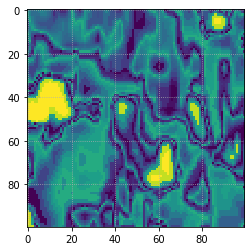

In [25]:
c = 87
image, label = next(iter(train_ds))
_ = plt.imshow(image[..., c])

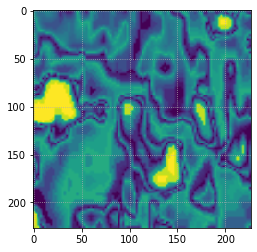

In [26]:
result = resize_and_rescale(image)
_ = plt.imshow(result[..., c])

In [27]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Resizing(IMG_SIZE + 10, IMG_SIZE + 10),
        #         layers.RandomFlip("horizontal_and_vertical", seed=SEED),
        #         layers.RandomRotation(0.3, seed=SEED),
        layers.RandomZoom((0.0, -0.3), seed=SEED),
        layers.RandomCrop(IMG_SIZE, IMG_SIZE, seed=SEED),
    ]
)
data_augmentation.build((None, IMG_SIZE, IMG_SIZE, N_CHANNELS))
data_augmentation.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 237, 237, 121)     0         
                                                                 
 random_zoom (RandomZoom)    (None, 237, 237, 121)     0         
                                                                 
 random_crop (RandomCrop)    (None, 227, 227, 121)     0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


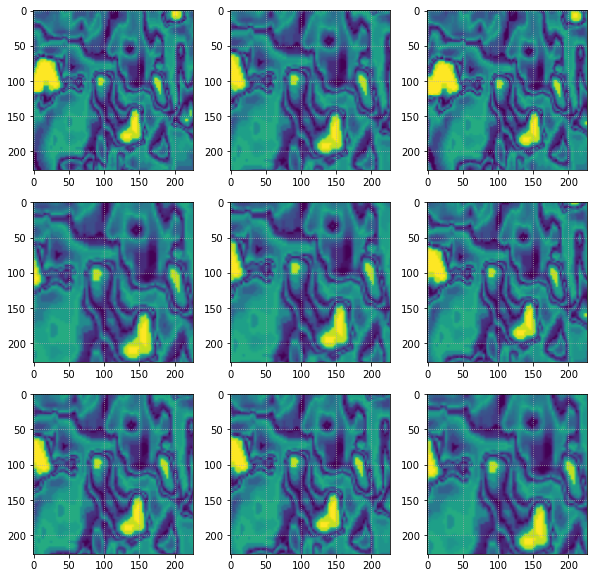

In [28]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(result)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[..., c])

In [29]:
result[..., c].numpy().min(), result[..., c].numpy().max()

(0.33333334, 0.8745098)

In [30]:
augmented_image[..., c].numpy().min(), augmented_image[..., c].numpy().max()

(0.33333334, 0.8745098)

In [31]:
def prepare_ds(ds, shuffle=False, augment=False):
    ds = ds.map(
        lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE
    )
    if shuffle:
        ds = ds.shuffle(tf.data.experimental.cardinality(ds).numpy())
    ds = ds.batch(BATCH_SIZE)
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )
    return ds.prefetch(buffer_size=AUTOTUNE)

In [32]:
train_ds = prepare_ds(train_ds, shuffle=True, augment=True)
test_ds = prepare_ds(test_ds)

In [33]:
train_ds, test_ds

(<PrefetchDataset shapes: ((None, 227, 227, 121), (None, 2)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 227, 227, 121), (None, 2)), types: (tf.float32, tf.float32)>)

## ```tf.image```

In [25]:
# def resize_and_rescale(image, label):
#     image = tf.cast(image, tf.float32)
#     image = tf.image.resize(image, [IMG_SIZE + 25, IMG_SIZE + 25])
#     image = tf.image.per_image_standardization(image)
#     return image, label

In [26]:
# def augment(image_label, seed):
#     rng = tf.random.Generator.from_seed(seed)
#     image, label = image_label
#     image, label = resize_and_rescale(image, label)
#     new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
#     image = tf.image.stateless_random_flip_left_right(image, seed=new_seed)
#     image = tfa.image.rotate(
#         image, rng.uniform([1], minval=-0.25, maxval=0.25)
#     )
#     image = tf.image.stateless_random_crop(
#         image, size=[IMG_SIZE, IMG_SIZE, N_CHANNELS], seed=new_seed
#     )
#     return image, label

In [27]:
# def visualize(original, augmented):
#     fig, axes = plt.subplots(1,2)
#     axes[0].set_title("Original image")
#     axes[0].imshow(original)

#     axes[1].set_title("Augmented image")
#     axes[1].imshow(augmented)

In [28]:
# image, label = next(iter(train_dataset))
# c = 99
# for i in range(5):
#     seed = (i, 0)  # tuple of size (2,)
#     aug = resize_and_rescale(image, label)
#     aug, _ = augment(aug, seed)
#     visualize(image[..., c], aug[..., c])

# AlexNet
- https://paperswithcode.com/paper/imagenet-classification-with-deep
- https://github.com/mikechen66/AlexNet_TensorFlow2.0-2.3/blob/master/alexnet.py
- https://github.com/yangna815/Mineral-Prospectivity-Prediction-Convolutional-Neural-Networks

In [40]:
# model = Sequential(
#     [
#         layers.Conv2D(
#             filters=128,
#             kernel_size=(11, 11),
#             strides=(4, 4),
#             activation="relu",
#             input_shape=(IMG_SIZE, IMG_SIZE, N_CHANNELS),
#             name="CONV1"
#         ),
#         layers.BatchNormalization(name="BatchNorm1"),
#         layers.MaxPool2D(pool_size=(2, 2), name="MAXPOOL1"),
#         layers.Conv2D(
#             filters=256,
#             kernel_size=(5, 5),
#             strides=(1, 1),
#             activation="relu",
#             padding="same",
#             name="CONV2"
#             # add kernel regularizer here?
#         ),
#         layers.BatchNormalization(name="BatchNorm2"),
#         layers.MaxPool2D(pool_size=(3, 3), name="MAXPOOL2"),
#         layers.Conv2D(
#             filters=256,
#             kernel_size=(3, 3),
#             strides=(1, 1),
#             activation="relu",
#             padding="same",
#             name="CONV3"
#         ),
#         layers.BatchNormalization(name="BatchNorm3"),
#         layers.Conv2D(
#             filters=256,
#             kernel_size=(1, 1),
#             strides=(1, 1),
#             activation="relu",
#             padding="same",
#             name="CONV4"
#         ),
#         layers.BatchNormalization(name="BatchNorm4"),
#         layers.Conv2D(
#             filters=256,
#             kernel_size=(1, 1),
#             strides=(1, 1),
#             activation="relu",
#             padding="same",
#             name="CONV5"
#         ),
#         layers.BatchNormalization(name="BatchNorm5"),
#         layers.MaxPool2D(pool_size=(2, 2), name="MAXPOOL3"),
#         layers.Flatten(),
#         layers.Dense(1024, activation="relu", name="FC1"),
#         layers.Dropout(0.5),
#         layers.Dense(1024, activation="relu", name="FC2"),
#         layers.Dropout(0.5),
#         layers.Dense(2, activation="softmax", name="FC3"),
#     ]
# )

# model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     optimizer=tf.optimizers.Adam(learning_rate=0.0001),
#     metrics=["accuracy"],
# )
# model.summary()

In [43]:
model = Sequential(
    [
        # No.1 Convolutional Layer: (227- 11 + 2 * 0) / 4 + 1 = 55
        layers.Conv2D(
            filters=96,
            kernel_size=(11, 11),
            strides=(4, 4),
            activation="relu",
            input_shape=(IMG_SIZE, IMG_SIZE, N_CHANNELS),
            kernel_initializer="GlorotNormal",
            name="CONV1",
        ),
        # Max Pooling: (55- 3 + 2 * 0) / 2 + 1 = 27
        layers.MaxPool2D(
            pool_size=(3, 3), strides=(2, 2), padding="valid", name="MAXPOOL1"
        ),
        
        # No.2 Conv Layer: (27- 5 + 2 * 2) / 1 + 1 = 27
        layers.Conv2D(
            filters=256,
            kernel_size=(5, 5),
            strides=(1, 1),
            activation="relu",
            padding="same",
            kernel_initializer="GlorotNormal",
            name="CONV2"
            # add kernel regularizer here?
        ),
        # Max Pooling: (27-  3 + 2 * 0) / 2 + 1 = 13
        layers.MaxPool2D(
            pool_size=(3, 3), strides=(2, 2), padding="valid", name="MAXPOOL2"
        ),
        
        # No.3 Conv Layer: (13 - 3 + 2 * 1) / 1 + 1 = 13
        layers.Conv2D(
            filters=384,
            kernel_size=(3, 3),
            strides=(1, 1),
            activation="relu",
            padding="same",
            kernel_initializer="GlorotNormal",
            name="CONV3",
        ),
        
        # No.4 Conv Layer: (13 - 3 + 2 * 1) / 1 + 1 = 13
        layers.Conv2D(
            filters=384,
            kernel_size=(3, 3),
            strides=(1, 1),
            activation="relu",
            padding="same",
            kernel_initializer="GlorotNormal",
            name="CONV4",
        ),
        
        # No.5 Conv Layer: (13 - 3 + 2 * 1) / 1 + 1 = 13
        layers.Conv2D(
            filters=256,
            kernel_size=(3, 3),
            strides=(1, 1),
            activation="relu",
            padding="same",
            kernel_initializer="GlorotNormal",
            name="CONV5",
        ),
        # Max Pooling: (13 - 3 + 2 * 0) / 2 + 1 =  6
        layers.MaxPool2D(
            pool_size=(3, 3), strides=(2, 2), padding="valid", name="MAXPOOL3"
        ),
        
        layers.Flatten(),
        
        # No.6 FC Layer 
        layers.Dense(4096, activation="relu", name="FC1"),
        layers.Dropout(0.5),
        
        # No.7 FC Layer   
        layers.Dense(4096, activation="relu", name="FC2"),
        layers.Dropout(0.5),
        
        # No.8 FC Layer
        layers.Dense(1000, activation="relu", name="FC3"),
        layers.Dense(2, activation="softmax", name="FC4"),
    ]
)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 55, 55, 96)        1405632   
                                                                 
 MAXPOOL1 (MaxPooling2D)     (None, 27, 27, 96)        0         
                                                                 
 CONV2 (Conv2D)              (None, 27, 27, 256)       614656    
                                                                 
 MAXPOOL2 (MaxPooling2D)     (None, 13, 13, 256)       0         
                                                                 
 CONV3 (Conv2D)              (None, 13, 13, 384)       885120    
                                                                 
 CONV4 (Conv2D)              (None, 13, 13, 384)       1327488   
                                                                 
 CONV5 (Conv2D)              (None, 13, 13, 256)      

In [44]:
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=test_ds,
    workers=7,
    use_multiprocessing=True,
)
model.save("./outputs/model_trained.tf")
to_pickle("./outputs/model_history.pkl", history.history)

Epoch 1/15
3/3 [==============================] - 14s 2s/step - loss: 1.6538 - accuracy: 0.4342 - val_loss: 1.3937 - val_accuracy: 0.4231
Epoch 2/15
3/3 [==============================] - 13s 2s/step - loss: 0.9538 - accuracy: 0.5395 - val_loss: 1.2748 - val_accuracy: 0.4615
Epoch 3/15
3/3 [==============================] - 13s 2s/step - loss: 0.9512 - accuracy: 0.5132 - val_loss: 0.9684 - val_accuracy: 0.4231
Epoch 4/15
3/3 [==============================] - 13s 2s/step - loss: 0.8108 - accuracy: 0.5789 - val_loss: 0.8823 - val_accuracy: 0.4231
Epoch 5/15
3/3 [==============================] - 13s 2s/step - loss: 0.7391 - accuracy: 0.6579 - val_loss: 0.8378 - val_accuracy: 0.5000
Epoch 6/15
3/3 [==============================] - 13s 2s/step - loss: 0.6546 - accuracy: 0.6184 - val_loss: 1.0438 - val_accuracy: 0.3462
Epoch 7/15
3/3 [==============================] - 13s 2s/step - loss: 0.6281 - accuracy: 0.6579 - val_loss: 1.0298 - val_accuracy: 0.3846
Epoch 8/15
3/3 [==================

INFO:tensorflow:Assets written to: ./outputs/model_trained.tf\assets


INFO:tensorflow:Assets written to: ./outputs/model_trained.tf\assets


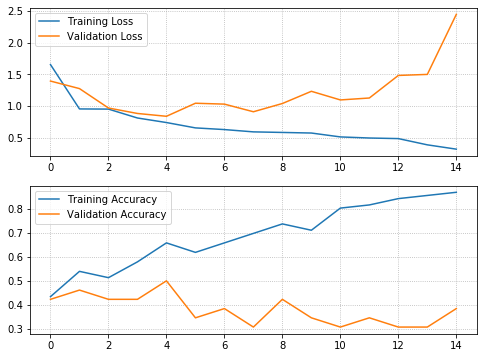

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(model.history.history["loss"], label="Training Loss")
axes[0].plot(model.history.history["val_loss"], label="Validation Loss")

axes[1].plot(model.history.history["accuracy"], label="Training Accuracy")
axes[1].plot(
    model.history.history["val_accuracy"], label="Validation Accuracy",
)
for ax in axes:
    ax.legend()

# Prediction

In [34]:
model = tf.keras.models.load_model("./outputs/model_trained.tf")

In [35]:
pred_ds = resize_and_rescale(pred_tensor)

In [36]:
pred = model.predict(pred_ds, workers=7, use_multiprocessing=True)

In [37]:
grid = np.concatenate((all_nodes, np.full((len(all_nodes), 2), np.nan)), axis=1)
mask = (grid[:, 2] == 0) & (grid[:, 3] == 1)
np.putmask(grid[:, -1], mask, pred)

In [38]:
def coord_to_2D_idx(x, y, xmin, ymin, xsize, ysize):
    """convert (x, y) to (ix, iy) with top left origin"""
    ix = (np.ceil((x - xmin) / xsize + 0.5) - 1).astype(int)
    iy = (np.ceil((y - ymin) / ysize + 0.5) - 1).astype(int)
    return ix, iy

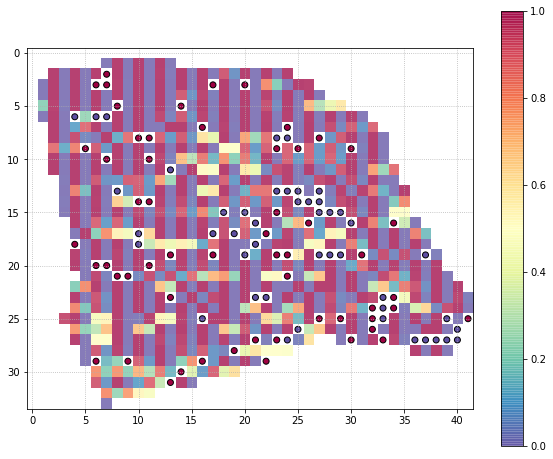

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = "Spectral_r"
training = centroids[centroids[:, 2] > 0]
im = ax.imshow(
    grid[:, -1].reshape(grid_spec["ny"], grid_spec["nx"]), cmap=cmap, alpha=0.75
)
ax.scatter(
    *coord_to_2D_idx(
        training[:, 0],
        training[:, 1],
        0,
        0,
        grid_spec["xsize"],
        grid_spec["ysize"],
    ),
    c=training[:, 2],
    cmap=cmap,
    ec="k"
)
_ = plt.colorbar(im, ax=ax)